In [1]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.omega import Omega, filter_spikes_by_time_range

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')
%config InlineBackend.figure_format = 'retina'

###############################################
###############################################

# For computing runtimes
from time import time as tm

In [14]:
# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(6)

# Discretized time
T=200 * 50
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Number of external, exc and inh neurons
Nx=400
Ne=800
Ni=200

In [15]:
# External neuron firing rates
rx=5/1000

# EIF neuron parameters
taum=10 
EL=-72 
Vre=-72 
VT=-55 
D=2 
Vth=0

# Synaptic time constants
taux=8
taue=6
taui=4 


# Generate external spike trains as Poisson processes
Sx=np.random.binomial(1,rx*dt,(Nx,len(time)))/dt

In [16]:
# Connection strengths
jex=30.0
jix=20.0
jee=12.0
jei=-45.0
jie=35.0
jii=-70.0


# Connection probabilities
pex=.2
pix=.2
pee=.2 
pei=.2 
pie=.2 
pii=.2

# Connection matrices
Jex=jex*np.random.binomial(1,pex,(Ne,Nx))
Jee=jee*np.random.binomial(1,pee,(Ne,Ne))
Jei=jei*np.random.binomial(1,pei,(Ne,Ni))
Jix=jix*np.random.binomial(1,pix,(Ni,Nx))
Jie=jie*np.random.binomial(1,pie,(Ni,Ne))
Jii=jii*np.random.binomial(1,pii,(Ni,Ni))


In [17]:
# Initialize membrane potentials randomly
Ve=np.random.rand(Ne)*(VT-EL)+EL
Vi=np.random.rand(Ni)*(VT-EL)+EL
# Initialize all else as zeros
Iex=np.zeros(Ne)
Iee=np.zeros(Ne)
Iei=np.zeros(Ne)
Iix=np.zeros(Ni)
Iie=np.zeros(Ni)
Iii=np.zeros(Ni)
Se=np.zeros((Ne,len(time)))
Si=np.zeros((Ni,len(time)))
t0=tm()
print('Running sim. This will take several seconds...')
for i in range(len(time)-1):

    # Euler step for membrane potentials
    Ve=Ve+dt*(-(Ve-EL)+D*np.exp((Ve-VT)/D)+Iex+Iee+Iei)/taum 
    Vi=Vi+dt*(-(Vi-EL)+D*np.exp((Vi-VT)/D)+Iix+Iie+Iii)/taum 
    

    # Euler step for synaptic currents
    Iex=Iex+dt*(-Iex+Jex@Sx[:,i])/taux      
    Iee=Iee+dt*(-Iee+Jee@Se[:,i])/taue
    Iei=Iei+dt*(-Iei+Jei@Si[:,i])/taui    
    Iix=Iix+dt*(-Iix+Jix@Sx[:,i])/taux    
    Iie=Iie+dt*(-Iie+Jie@Se[:,i])/taue
    Iii=Iii+dt*(-Iii+Jii@Si[:,i])/taui
    
        
    # Find which excitatory neurons spiked.
    Inds=np.nonzero(Ve>=Vth)[0]
    # Reset membrane potentials
    Ve[Inds]=Vre    
    # Store spikes as delta functions
    Se[Inds,i+1]=1/dt
        
    # Now do the same for inhibitory neurons
    Inds=np.nonzero(Vi>=Vth)[0] 
    # Reset membrane potentials
    Vi[Inds]=Vre
    # Store spikes as delta functions
    Si[Inds,i+1]=1/dt


print('time for sim = ',tm()-t0,'s')

Running sim. This will take several seconds...
time for sim =  127.00629162788391 s


In [18]:
# Mean-field connectivity
wex=jex*pex*Nx 
wix=jix*pix*Nx 
wee=jee*pee*Ne 
wei=jei*pei*Ni 
wie=jie*pie*Ne
wii=jii*pii*Ni 
W=np.array([[wee, wei],  [wie, wii]])
X=np.array([wex*rx, wix*rx])

# Get spike times and neuron indices
[SxIndices,SxTimes]=np.nonzero(Sx) 
SxTimes=SxTimes*dt 
[SeIndices,SeTimes]=np.nonzero(Se) 
SeTimes=SeTimes*dt 
[SiIndices,SiTimes]=np.nonzero(Si) 
SiTimes=SiTimes*dt 

In [19]:
# g and theta from the fit in EIFficurve.ipynb
g = 0.00358
theta = 9.64

# Mean-field approx to fixed point rates
rBarMF=np.linalg.inv(np.eye(2)-g*W)@(X-theta)*g
print('Statiomary mean field rates: re =',1000*rBarMF[0],'Hz, ri =',1000*rBarMF[1],'Hz')


# Compute population-averged rates across time
re=np.mean(Se,axis=0)
ri=np.mean(Si,axis=0)

# Smooth the population-averaged rates
sigma=6
s=np.arange(-3*sigma,3*sigma,dt)
k=np.exp(-(s**2)/(2*sigma**2)) # Gaussian kernel
k[s<0]=0 # Make it causal
k=k/(sum(k)*dt)
re=np.convolve(k,re,'same')*dt
ri=np.convolve(k,ri,'same')*dt

Statiomary mean field rates: re = 2.032528454433477 Hz, ri = 3.163727363432724 Hz


In [24]:
t_start, t_end= T-200*10, T
filtered_SeTimes, filtered_SeIndices, filtered_SiTimes, filtered_SiIndices = filter_spikes_by_time_range(SeTimes, SeIndices, SiTimes, SiIndices, t_start, t_end)

/tmp/ipykernel_14531/1453247174.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


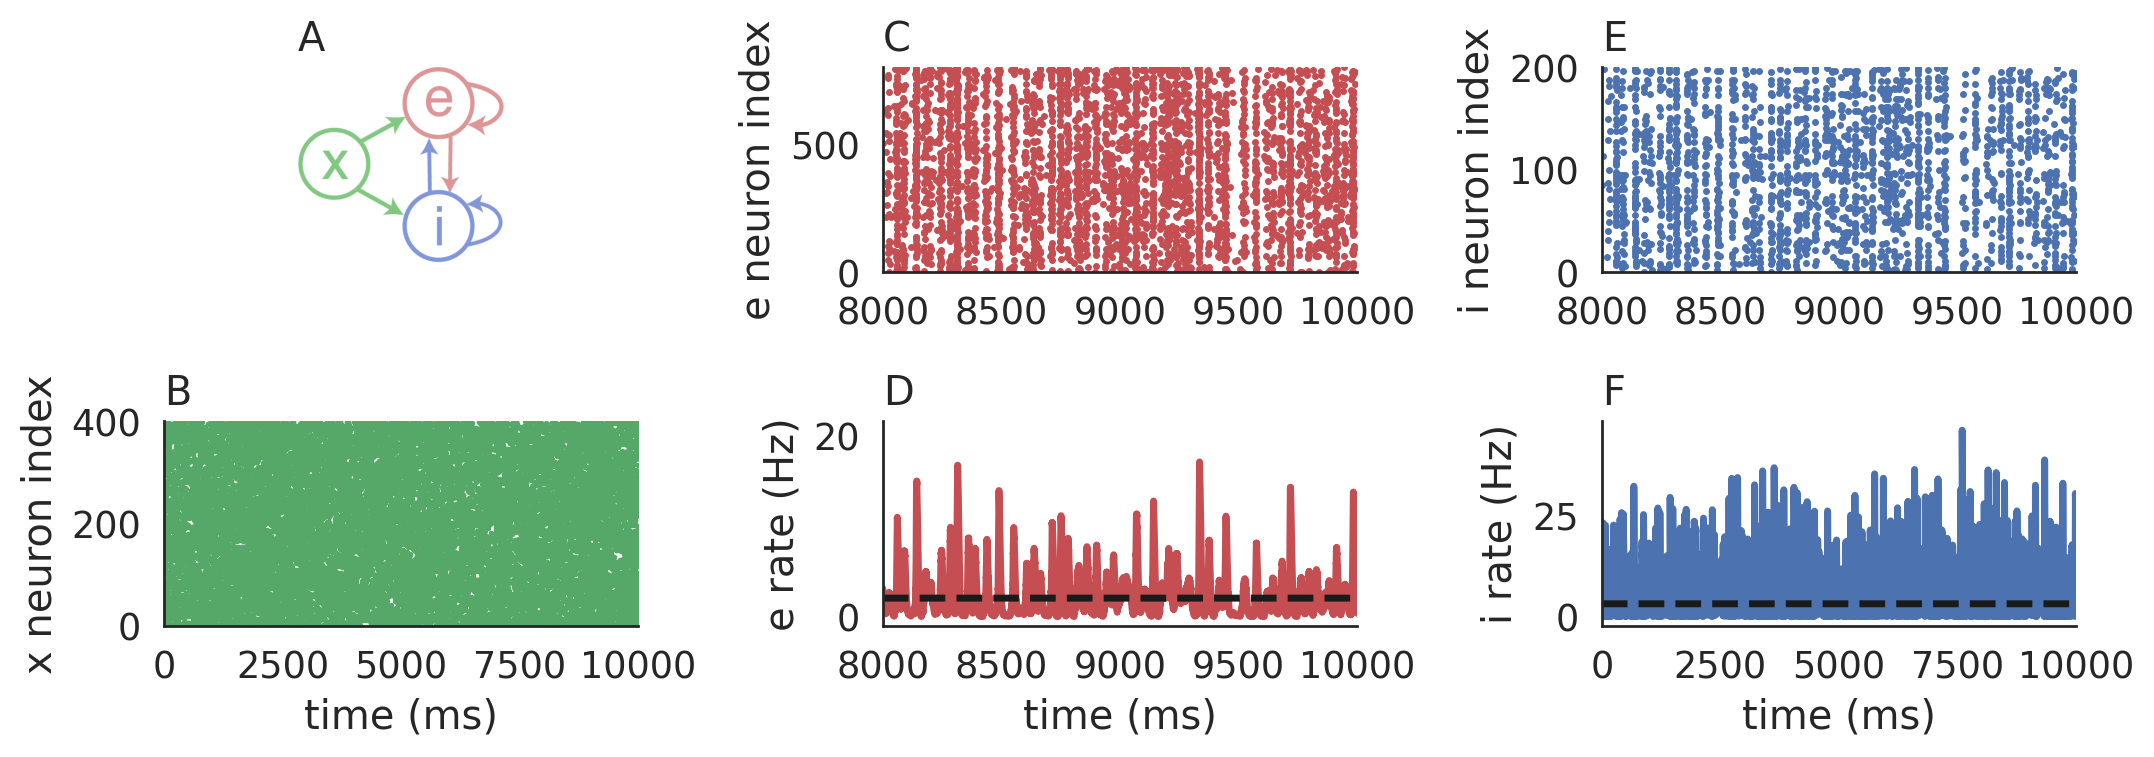

In [25]:
# Make figure
plt.subplots(figsize=(11, 4))

plt.subplot(2,3,1)
# Get image for plot
# Get image for plot
try: 
    im = plt.imread('./ImageFiles/EIRecurrentNet.png')
except:
    try:
        url = "https://raw.githubusercontent.com/RobertRosenbaum/ModelingNeuralCircuits/master/CodeFromBook/ImageFiles/EIRecurrentNet.png"
        file = np.DataSource().open(url)
        im = plt.imread(file.name)
    except:
        im = 1.0+np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('A',loc='left')

plt.subplot(2,3,4)
plt.plot(SxTimes,SxIndices,'g.',markersize=2)
plt.xlabel('time (ms)')
plt.xlim([0,T])
plt.ylim([0,Nx])
plt.ylabel('x neuron index')
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,2)
plt.plot(filtered_SeTimes, filtered_SeIndices,'r.',markersize=3)
plt.xlim([t_start,T])
plt.ylim([0,Ne])
#plt.xlabel('time (ms)')
plt.ylabel('e neuron index')
plt.title('C',loc='left')
sns.despine()

plt.subplot(2,3,5)
plt.plot(time,1000*re,'r')
plt.plot(time,1000*rBarMF[0]+np.zeros_like(time),'k--')
plt.xlim([t_start,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title('D',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(filtered_SiTimes, filtered_SiIndices,'b.',markersize=3)
plt.xlim([t_start,T])
plt.ylim([0,Ni])
#plt.xlabel('time (ms)')
plt.ylabel('i neuron index')
plt.title('E',loc='left')
sns.despine()

plt.subplot(2,3,6)
plt.plot(time,1000*ri,'b')
plt.xlim([0,T])
plt.plot(time,1000*rBarMF[1]+np.zeros_like(time),'k--')
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('F',loc='left')
sns.despine()


plt.tight_layout()


In [26]:
omega_test = Omega(Jie, filtered_SeTimes, filtered_SeIndices, filtered_SiTimes, filtered_SiIndices)
print(len(omega_test))

4222703


150


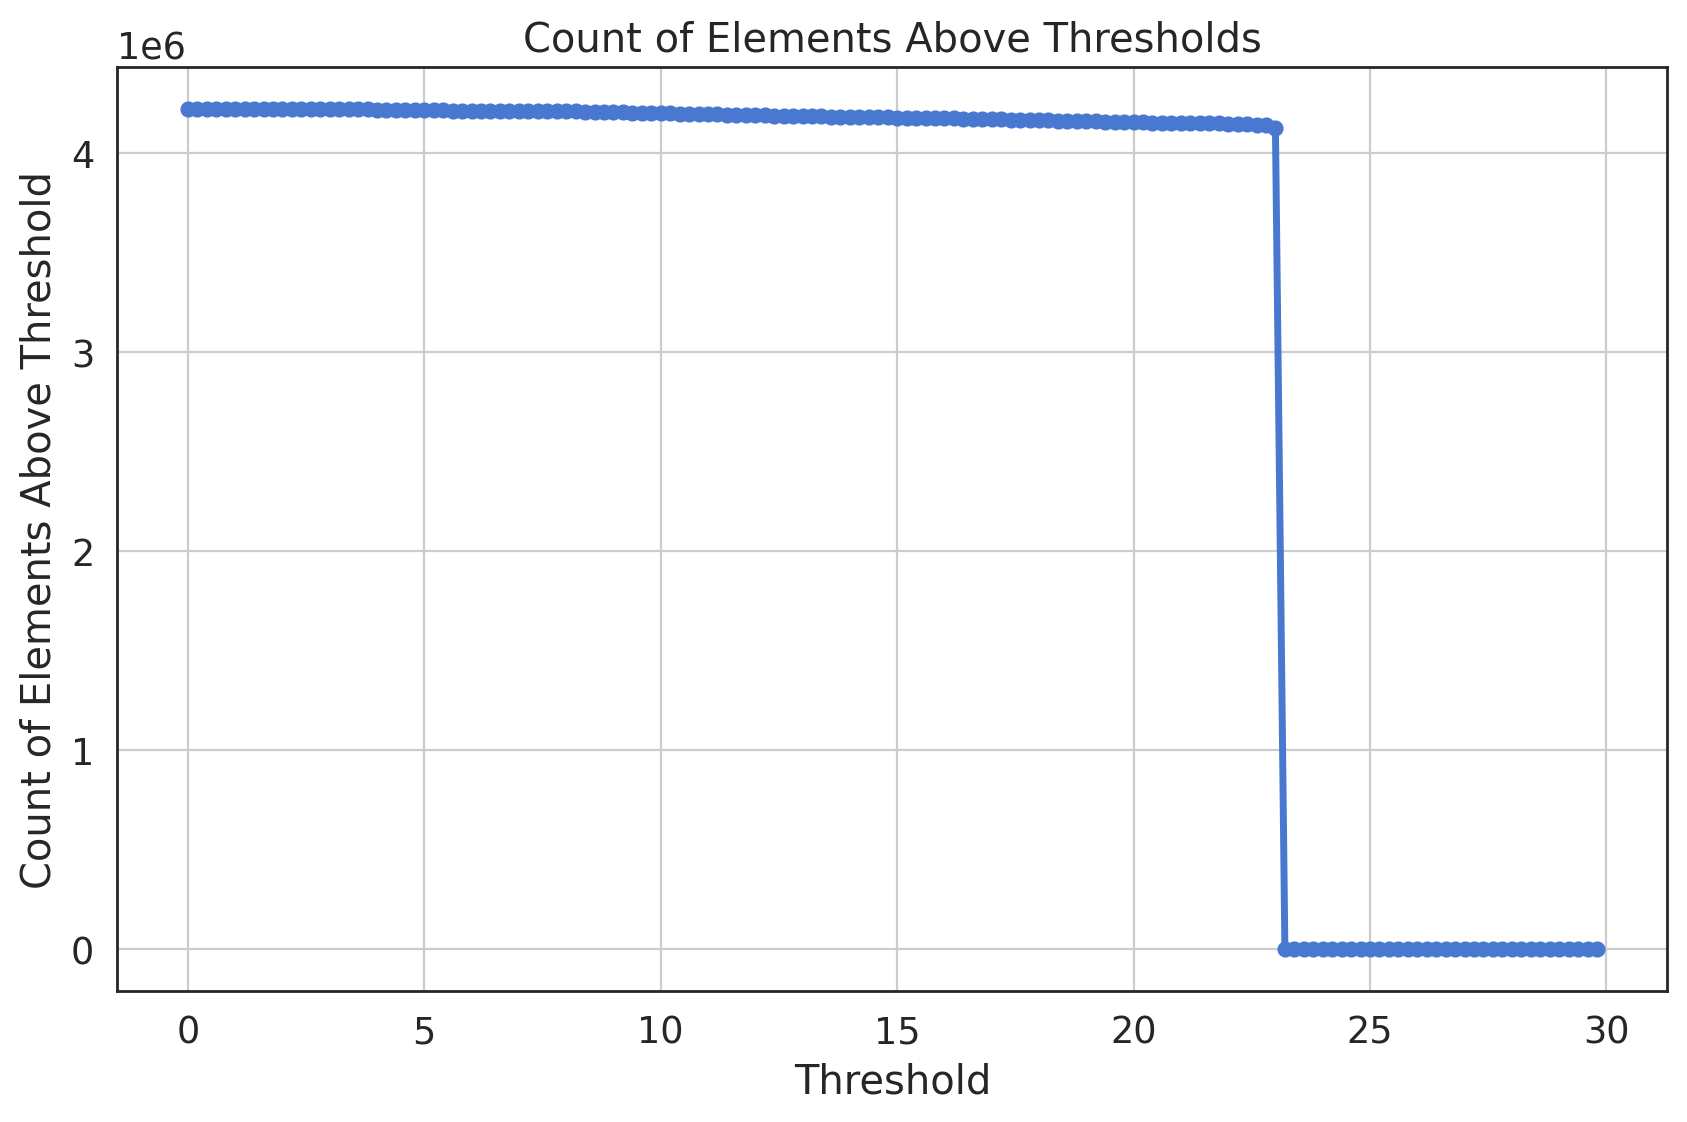

In [28]:
# Extracting the last values from each 5-tuple
last_values = np.array(omega_test)[:, -1]
last_values_logged = -np.log(last_values + 1e-10)
# Threshold values
thresholds = np.arange(0, 30, 0.2)  # From 0 to 30

# Counting the number of elements with the last value above each threshold
counts = [np.sum(last_values_logged > threshold) for threshold in thresholds]
print(len(counts))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, counts, marker='o')
plt.title('Count of Elements Above Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Count of Elements Above Threshold')
plt.grid(True)
plt.show()



<generator object <genexpr> at 0x7f8890ba29e0>


(200, 800)
